<a href="https://colab.research.google.com/github/aesnin12/CSMODELProject/blob/main/CSMODEL_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Variable Descriptions of the dataset

| Variable | Description |
|-----------|-------------|
| Variable          | Description                                               |
| ----------------- | --------------------------------------------------------- |
| `Name`            | Title of the video game                                   |
| `Platform`        | The gaming platform (e.g. Wii, NES, PS4)                  |
| `Year_of_Release` | Year when the game was released                           |
| `Genre`           | Genre (category) of the game (e.g. Sports, Racing)        |
| `Publisher`       | Company that published the game                           |
| `NA_Sales`        | Sales in North America (in millions of units)             |
| `EU_Sales`        | Sales in Europe (in millions of units)                    |
| `JP_Sales`        | Sales in Japan (in millions of units)                     |
| `Other_Sales`     | Sales in the rest of the world (in millions of units)     |
| `Global_Sales`    | Total worldwide sales (in millions of units)              |
| `Critic_Score`    | Average critic review score (typically 0–100)             |
| `Critic_Count`    | Number of critic reviews used to compute the critic score |
| `User_Score`      | Average user review score (typically on a 0–10 scale)     |
| `User_Count`      | Number of user reviews used to compute the user score     |
| `Developer`       | Studio or company that developed the game                 |
| `Rating`          | Age/content rating (e.g. ESRB ratings: E, T, M, etc.)     |

## Dataset Cleaning and Setup



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from scipy.stats import ttest_ind, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("kendallgillies/video-game-sales-and-ratings")

print("Path to dataset files:", path)

df = pd.read_csv(os.path.join(path, "Video_Game_Sales_as_of_Jan_2017.csv"))
df.head()

Using Colab cache for faster access to the 'video-game-sales-and-ratings' dataset.
Path to dataset files: /kaggle/input/video-game-sales-and-ratings


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.54,76.0,51.0,8.0,324.0,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.80,3.79,3.29,35.57,82.0,73.0,8.3,712.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.95,3.28,2.95,32.78,80.0,73.0,8.0,193.0,E
4,Pokemon Red/Pokemon Blue,G,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17416 entries, 0 to 17415
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             17416 non-null  object 
 1   Platform         17416 non-null  object 
 2   Year_of_Release  17408 non-null  float64
 3   Genre            17416 non-null  object 
 4   Publisher        17415 non-null  object 
 5   NA_Sales         17416 non-null  float64
 6   EU_Sales         17416 non-null  float64
 7   JP_Sales         17416 non-null  float64
 8   Other_Sales      17416 non-null  float64
 9   Global_Sales     17416 non-null  float64
 10  Critic_Score     8336 non-null   float64
 11  Critic_Count     8336 non-null   float64
 12  User_Score       7798 non-null   float64
 13  User_Count       7798 non-null   float64
 14  Rating           10252 non-null  object 
dtypes: float64(10), object(5)
memory usage: 2.0+ MB


In [ ]:
df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')
df['Critic_Score'] = pd.to_numeric(df['Critic_Score'], errors='coerce')
df['Year_of_Release'] = pd.to_numeric(df['Year_of_Release'], errors='coerce')

df = df.dropna(subset=['Global_Sales', 'Critic_Score', 'User_Score', 'Year_of_Release'])


In [ ]:
platform_counts = df["Platform"].value_counts(dropna=False)
print(platform_counts)

Platform
PS2     1169
X360     892
PS3      797
PC       779
X        587
Wii      494
DS       473
PSP      401
GC       363
PS4      265
GBA      249
XOne     175
3DS      162
PS       157
PSV      125
WiiU      89
DC        14
Name: count, dtype: int64


##### Make platforms in each perspective company (Playstation, Xbox, Nintendo, PC, or Other)

In [ ]:
platform_groups = {
    "PlayStation": ["PS", "PS2", "PS3", "PS4", "PSP", "PSV"],
    "Xbox": ["X", "X360", "XONE"],
    "Nintendo": ["NES", "SNES", "N64", "GC", "WII", "WIIU", "GBA", "DS", "3DS", "G"],  # G = Game Boy
    "PC": ["PC"],
    "Sega": ["GEN", "SAT", "DC", "SCD", "GG"],
    "Atari": ["2600"],
    "NEC": ["TG16", "PCFX"],
    "SNK": ["NG"],
    "Bandai": ["WS"],
    "Panasonic": ["3DO"],
}

# Clean and standardize platform names
df["Platform"] = df["Platform"].astype(str).str.strip().str.upper()

# Function to categorize each platform
def categorize_platform(p):
    for group, names in platform_groups.items():
        if p in names:
            return group
    return "Other"

# Apply the grouping and overwrite the column
df["Platform"] = df["Platform"].apply(categorize_platform)

##### Replace RP (Rating Pending) to just none.

In [ ]:
df['Rating'].replace('RP', 'No Rating', inplace=True)
df['Rating'].fillna('No Rating', inplace=True)

/tmp/ipython-input-127132537.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Rating'].replace('RP', 'No Rating', inplace=True)
/tmp/ipython-input-127132537.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

## Exploratory Data Analysis

##### For EDA, we can specify video game success criteria by two definitions: (1) Sales success, (2) Critical sucess or both. For this we will use the variables (1) Genre (2) Critic and User scores (3) Platforms and (4) Publishers. In this EDA we will more focus on Sales success by correlating them in the said variables.

### EDA Question 1: Which game genres are associated with higher global sales?

In [ ]:
genre_sales = df.groupby('Genre')['Global_Sales'].agg(['mean', 'median', 'sum', 'count']).sort_values(by='mean', ascending=False)
genre_sales

,mean,median,sum,count
Genre,,,,
Misc,1.066309,0.380,427.59,401
Shooter,0.930631,0.320,841.29,904
Platform,0.930121,0.345,383.21,412
Sports,0.871648,0.380,862.06,989
Racing,0.798847,0.270,484.90,607
Action,0.724667,0.290,1242.08,1714
Role-Playing,0.689987,0.250,512.66,743
Simulation,0.668082,0.290,212.45,318
Fighting,0.646260,0.330,253.98,393


/tmp/ipython-input-1283359416.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_sales.reset_index(), x='Genre', y='mean', palette='viridis')


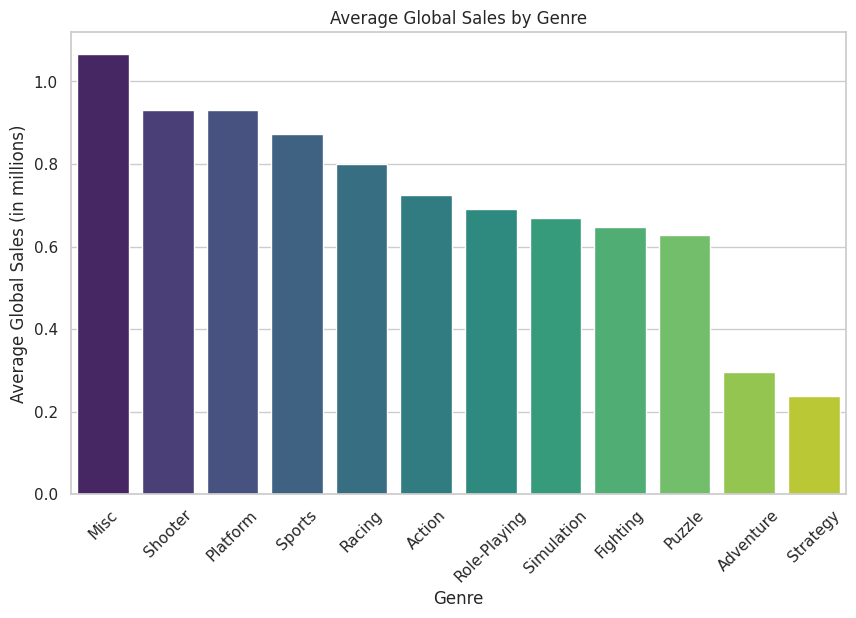

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=genre_sales.reset_index(), x='Genre', y='mean', palette='viridis')
plt.title('Average Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Global Sales (in millions)')
plt.xticks(rotation=45)
plt.show()

###### Excluding the `Miscellaneous` genre, the data reveals that `Shooter` games have the highest average global sales among all video game genres. This indicates that shooter titles tend to perform exceptionally well in the global market compared to other genres such as `Platform`, `Sports`, or `Racing` games. The popularity of `Shooter` games may be attributed to their broad appeal, competitive gameplay, and strong player engagement across different regions. Overall, this suggests that the shooter genre holds a dominant position in terms of commercial success within the gaming industry.

### EDA Question 2: How do critic and user scores relate to global sales?

In [ ]:
df[['Critic_Score', 'User_Score', 'Global_Sales']].corr()

,Critic_Score,User_Score,Global_Sales
Critic_Score,1.000000,0.582705,0.236805
User_Score,0.582705,1.000000,0.088211
Global_Sales,0.236805,0.088211,1.000000


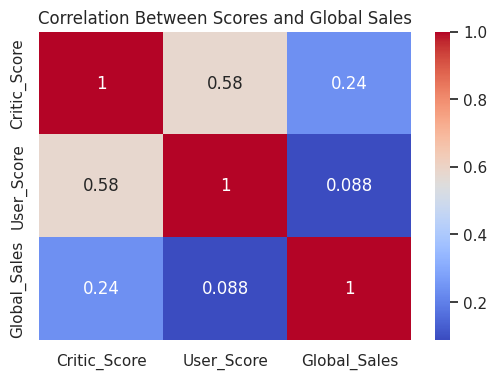

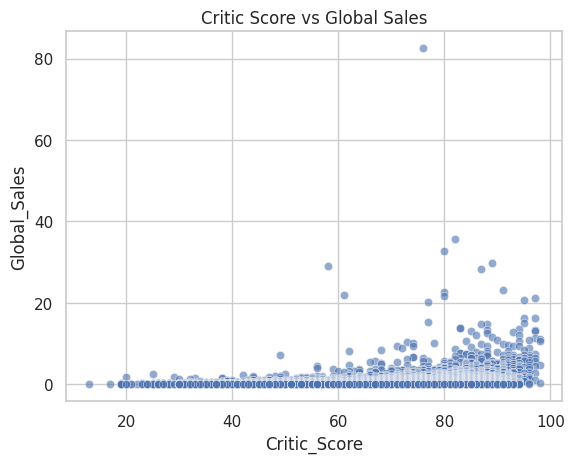

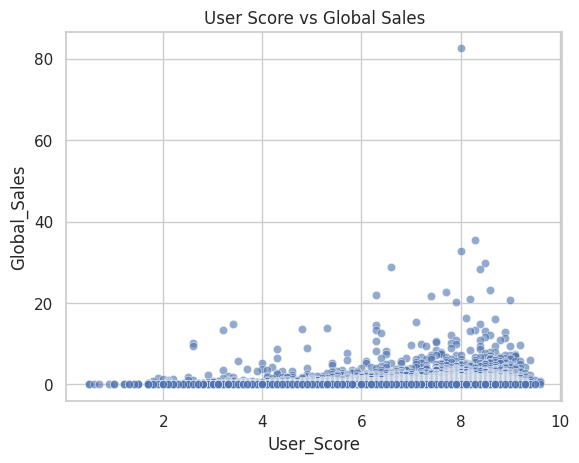

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['Critic_Score', 'User_Score', 'Global_Sales']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Scores and Global Sales')
plt.show()

sns.scatterplot(data=df, x='Critic_Score', y='Global_Sales', alpha=0.6)
plt.title('Critic Score vs Global Sales')
plt.show()

sns.scatterplot(data=df, x='User_Score', y='Global_Sales', alpha=0.6)
plt.title('User Score vs Global Sales')
plt.show()

##### The correlation heatmap and scatter plots show that there is a weak positive correlation (r = 0.24) between `Critic_Score` and `Global_Sales`. This suggests that while games with higher critic ratings tend to sell slightly better worldwide, the relationship is not particularly strong. In other words, although positive critic reviews may contribute to improved sales, they are not the sole determinant of a game's commercial success.

##### In contrast, the correlation between `User_Score` and `Global_Sales` is even weaker (r = 0.09), indicating that player ratings have minimal direct influence on overall sales performance. This could imply that user opinions, while valuable for community perception, do not necessarily translate into higher revenue.

##### Overall, the findings suggest that well-reviewed games (especially by critics) often achieve higher sales, but a good review alone does not guarantee commercial success — other factors such as marketing, franchise reputation, platform exclusivity, and release timing may play more substantial roles in driving sales.

### EDA Question 3: Which gaming platforms tend to have higher-selling games?

In [ ]:
platform_sales = df.groupby('Platform')['Global_Sales'].agg(['mean', 'median', 'sum', 'count']).sort_values(by='mean', ascending=False)
platform_sales

,mean,median,sum,count
Platform,,,,
Nintendo,0.851705,0.280,1558.62,1830
PlayStation,0.845528,0.370,2463.87,2914
Xbox,0.743065,0.295,1229.03,1654
Sega,0.325000,0.195,4.55,14
PC,0.255212,0.050,198.81,779


/tmp/ipython-input-3294420829.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=platform_sales.reset_index(), x='Platform', y='mean', palette='magma')


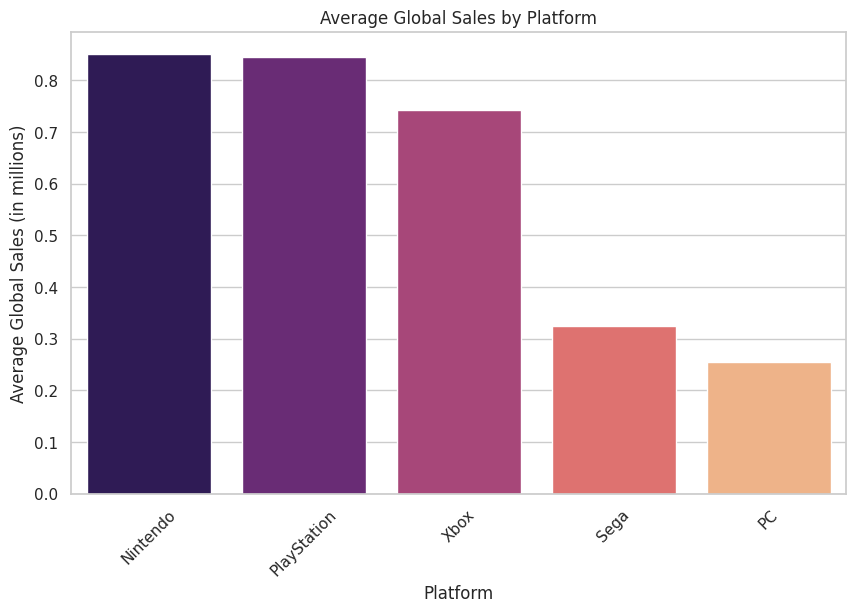

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=platform_sales.reset_index(), x='Platform', y='mean', palette='magma')
plt.title('Average Global Sales by Platform')
plt.xlabel('Platform')
plt.ylabel('Average Global Sales (in millions)')
plt.xticks(rotation=45)
plt.show()

#### The analysis shows an extremely close competition between `Nintendo` and `PlayStation`. Nintendo leads with an average of 0.852 million units sold per game, while `PlayStation` follows closely at 0.846 million units. This tiny gap suggests that both platforms have been almost equally successful in driving game sales, with `Nintendo` holding only a slight edge in overall performance.

### EDA Question 4: Who are the top publishers in terms of global sales performance?

In [ ]:
publisher_sales = df.groupby('Publisher')['Global_Sales'].agg(['mean', 'sum', 'count']).sort_values(by='sum', ascending=False).head(10)
publisher_sales

,mean,sum,count
Publisher,,,
Electronic Arts,0.924095,898.22,972
Nintendo,2.877433,863.23,300
Activision,1.074384,549.01,511
Sony Computer Entertainment,1.220741,395.52,324
Take-Two Interactive,1.261454,355.73,282
Ubisoft,0.672471,348.34,518
Microsoft Game Studios,1.512069,219.25,145
THQ,0.526006,164.64,313
Sega,0.508904,153.18,301


/tmp/ipython-input-11898410.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=publisher_sales.reset_index(), x='Publisher', y='sum', palette='cubehelix')


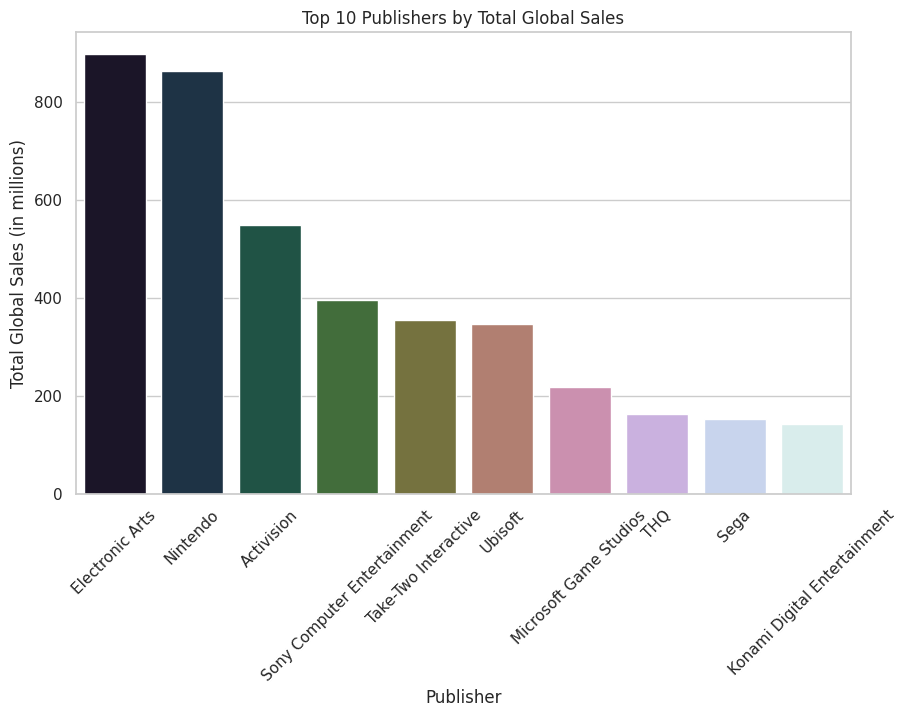

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=publisher_sales.reset_index(), x='Publisher', y='sum', palette='cubehelix')
plt.title('Top 10 Publishers by Total Global Sales')
plt.xlabel('Publisher')
plt.ylabel('Total Global Sales (in millions)')
plt.xticks(rotation=45)
plt.show()


##### `Electronic Arts` (EA) leads all publishers with the highest total global sales, demonstrating its strong dominance in the gaming industry through successful franchises such as FIFA, Battlefield, and The Sims. Following closely behind is `Nintendo`, whose iconic series like Mario, The Legend of Zelda, and Pokémon continue to drive impressive worldwide sales. Other major publishers, including Activision, Sony Computer Entertainment, Take-Two Interactive, and Ubisoft, also maintain significant market shares but remain behind EA and Nintendo in overall performance. This highlights EA’s position as the top-performing publisher globally in terms of video game sales.



EDA Question	Key Insights
1. In Genre + Sales, tend to generate higher average and total sales.
2. Scores + Sales,	Moderate positive correlation with Critic Scores; weaker with User Scores.
3. Platform + Sales,	Platforms like PlayStation or Nintendo have higher-selling games on average.
4. Publisher + Sales, EA, Nintendo and Activision account for a large share of total global sales.

# **Main Research Question:**
  What determines a game's success in terms of global sales?

### **Importance and Significance:**
  Factors such as game genre, critic and user scores, platform, publisher, and region may be important factors that determines how a game will sell in the global market. Through this research question, the team aims to understand how these factors correlate with each other and what needs to be tested for its significance so that future developers can see how they should market their game.

### **How this can benefit game studios:**
An upcoming or present game studio will be able to give an educated decision on the following example questions:

* Which publishing studio is the most competitive and yields the most global sales?

* How can we find the most success if the game studio aims for a region-based localization approach.

  *(Ex. Japanese game studio aiming to release games only in Japan.)*
* What platforms do this game's genre see more success in?
* Do games released on more platforms actually sell more?



# **Data modeling:**

To answer the research question "what determines a game's success in terms of global sales?", we need to first get a measurable defintion of success, we first defined success as a game for reaching ≥ 1.0 million global sales, which is a common industry benchmark for a financially successful "hit" game

The video game industry commonly uses the term “million-seller” to classify commercially successful titles. Several academic studies categorize game sales using the 1M threshold as the lower boundary for high-performing games. Major publishers such as Nintendo and Sony publicly report games surpassing 1M copies as key milestones. Therefore, using 1M global sales as the benchmark provides a meaningful and industry-recognized definition of game success.

Putra, Rafi. (2025). Classification and Prediction of Video Game Sales Levels Using the Naive Bayes Algorithm Based on Platform, Genre, and Regional Market Data. IJIIS: International Journal of Informatics and Information Systems. 8. 12-21. 10.47738/ijiis.v8i1.242.

we created a binary target variable:
* 1 = Hit game (≥ 1M sales)
* 0 = Non-hit game

With this in hand, we can build a predictive model that reveals which feature contributes the most to making a game successful

In [ ]:
df_model = df.dropna(subset = ['Global_Sales']).copy()

#define binary sucess label
df_model['is_hit'] = (df_model['Global_Sales'] >= 1.0).astype(int)

print(df_model['is_hit'].value_counts())
print(df_model['is_hit'].value_counts(normalize = True))


is_hit
0    5847
1    1344
Name: count, dtype: int64
is_hit
0    0.8131
1    0.1869
Name: proportion, dtype: float64


# Feature enginering:

## To understand what factors determine a game’s success we prepared the following predictors:

## Numeric Predictors

* Critic_Score — professional reviews

* User_Score — player reviews

* Year_of_Release — timing effects

* platform_count — number of platforms the game was released on

## Categorical Predictors

* Genre

* Platform

* Publisher_grouped (top publishers kept, others grouped as “Other”)

### These match the key variables explored earlier during EDA.

In [ ]:
top_publishers = df_model['Publisher'].value_counts().head(10).index
df_model['Publisher_grouped'] = np.where(
    df_model['Publisher'].isin(top_publishers),
    df_model['Publisher'],
    'Other'
)

platform_counts = df_model.groupby('Name')['Platform'].transform('nunique')
df_model['platform_count'] = platform_counts

feature_cols = [
    'Critic_Score', 'User_Score', 'Year_of_Release',
    'platform_count', 'Genre', 'Platform', 'Publisher_grouped'
]

## data cleaning

In [ ]:
df_model_clean = df_model.dropna(subset=['Critic_Score', 'User_Score', 'Year_of_Release'])
print(len(df_model_clean))

7191


# Model building

to determine which factors contributes to a game's success, logistic regression is used because
* it predicts a binary outcome (hit or not hit)
* it provides coefficients, showing which feature increases or decreases the probability of success
* it is pretty interpretable and can directyly answer what determines success

In [ ]:
X = df_model_clean[feature_cols]
y = df_model_clean['is_hit']
numeric_features = ['Critic_Score', 'User_Score', 'Year_of_Release', 'platform_count']
categorical_features = ['Genre', 'Platform', 'Publisher_grouped']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Critic_Score', 'User_Score',
                                                   'Year_of_Release',
                                                   'platform_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Genre', 'Platform',
                                                   'Publisher_grouped'])])),
                ('model', LogisticRegression(max_iter=1000))])

## Evaluation metrics
* Accuracy - how many predictions were correct overall
* Precision - when the model predicts a hit, how often is it correct?
* Recall - how many real hits did the model catch
* F1-score - balanced measure of precision and recall
* Confusion Matrix - Shows where the model was right or wrong
  
| hit | Predicted Non-Hit |Predicted Hit|
|-----------|-------------|-------------|
| Actual Non-Hit| True Negative| False Positive|
| Actual Hit| False Negative| True Positive|

In [ ]:
y_pred = clf.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy : 0.8561501042390549
Precision: 0.75
Recall   : 0.34572490706319703
F1-score : 0.4732824427480916

Confusion Matrix:
 [[1139   31]
 [ 176   93]]


## model evaluation
* accuracy - 85.65%, meaning it predicts the game success reasonablly well however because most games are non-hits in this dataset, the accuracy itself can be misleading
* precision - 75% ,shows that when the model predicts "hit or success" it is 75% correct of the time, this is good and it means that the model makes few false hit predictions
* recall - 0.346 , this indicates the model only indetifies 1/3 of actual hit games, missing many successful titles, but overall expected due to the imbalance dataset of hits and non-hits where the hits is way higher than the non-hits
* f1 score - 0.473 reflects moderate balance between precision and recall
* confusion matrix
  
| hit | Predicted Non-Hit |Predicted Hit|
|-----------|-------------|-------------|
| Actual Non-Hit| 1139 correct non-hit prediction (True Negative)| 31 false hit prediction (False Positive)|
| Actual Hit| 176 missed hit prediction (False Negative)| 93 correct hit predictions (True Positive)|

In [ ]:
log_reg = clf.named_steps['model']
ohe = clf.named_steps['preprocess'].named_transformers_['cat']

cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': log_reg.coef_[0],
    'abs_coef': np.abs(log_reg.coef_[0])
})


In [ ]:
coef_df['clean_feature'] = (
    coef_df['feature']
    .str.replace("Publisher_grouped_", "", regex=False)
    .str.replace("Platform_", "", regex=False)
    .str.replace("Genre_", "", regex=False)
)

In [ ]:
def get_category(name):
    if name.startswith("Publisher_grouped_"):
        return "Publisher"
    elif name.startswith("Platform_"):
        return "Platform"
    elif name.startswith("Genre_"):
        return "Genre"
    else:
        return "Numeric"

In [ ]:
coef_df['Category'] = coef_df['feature'].apply(get_category)

In [ ]:
print("\n📌 PUBLISHERS\n")
display(coef_df[coef_df['Category'] == 'Publisher']
        .sort_values('abs_coef', ascending=False)
        [['clean_feature', 'coefficient', 'abs_coef']])


📌 PUBLISHERS



,clean_feature,coefficient,abs_coef
25,Nintendo,1.530251,1.530251
23,Konami Digital Entertainment,-0.877375,0.877375
26,Other,-0.575480,0.575480
24,Namco Bandai Games,-0.416210,0.416210
31,Ubisoft,-0.345793,0.345793
27,Sega,-0.272517,0.272517
29,THQ,-0.263526,0.263526
22,Electronic Arts,0.256133,0.256133
28,Sony Computer Entertainment,-0.106077,0.106077
30,Take-Two Interactive,-0.039011,0.039011


In [ ]:
print("\n📌 PLATFORMS\n")
display(coef_df[coef_df['Category'] == 'Platform']
        .sort_values('abs_coef', ascending=False)
        [['clean_feature', 'coefficient', 'abs_coef']])


📌 PLATFORMS



,clean_feature,coefficient,abs_coef
17,PC,-1.279842,1.279842
19,Sega,-1.009168,1.009168
18,PlayStation,0.769694,0.769694
20,Xbox,0.247180,0.247180
16,Nintendo,0.164126,0.164126


In [ ]:
print("\n📌 GENRES\n")
display(coef_df[coef_df['Category'] == 'Genre']
        .sort_values('abs_coef', ascending=False)
        [['clean_feature', 'coefficient', 'abs_coef']])


📌 GENRES



,clean_feature,coefficient,abs_coef
15,Strategy,-1.108031,1.108031
5,Adventure,-0.880166,0.880166
14,Sports,-0.629518,0.629518
7,Misc,0.469344,0.469344
13,Simulation,0.382485,0.382485
12,Shooter,0.324380,0.324380
9,Puzzle,-0.312058,0.312058
8,Platform,0.243941,0.243941
4,Action,0.222760,0.222760
6,Fighting,0.155998,0.155998


In [ ]:
print("\n📌 NUMERIC FEATURES\n")
display(coef_df[coef_df['Category'] == 'Numeric']
        .sort_values('abs_coef', ascending=False)
        [['clean_feature', 'coefficient', 'abs_coef']])


📌 NUMERIC FEATURES



,clean_feature,coefficient,abs_coef
0,Critic_Score,1.404544,1.404544
1,User_Score,-0.246660,0.246660
3,platform_count,0.167834,0.167834
2,Year_of_Release,-0.039377,0.039377


The model shows that a game's success is strongly influenced by **Publisher Reputation**, **Critics Review Socres**, **Platforms**, and **genre**. **Nitendo-published** games and titles with higher critic scores have a much greater chance of reaching 1 million global sales. **PlayStation** releases tend to perform better than other, while **PC** and niche genres like **Strategy** and **Adventure** are less likely to producce hit games. Although the model has high accuracy and good precision, it struggles to detect all successfull games due to classs imbalance. Overall, both **game quality** and **market factors** determine whether a game becomes a commercial success

# Statistical Inference

### 1. Do games released on multi-platforms sell more in terms of global sales?

### Two Tailed T Test on Two Independent Sample Means<br>
Null Hypothesis: There is no significant difference between the mean global sales of multi-platform and single-platform games.<br>
Alternative Hypothesis: There is a significant difference between the mean global sales of multi-platform and single-platform games.

$$
H_0: \mu_{\text{multi}} = \mu_{\text{single}}
$$

$$
H_1: \mu_{\text{multi}} \neq \mu_{\text{single}}
$$


Each game's platform was counted based on how many platforms it has appeared on.
Duplicates were removed and two samples were retrieved based on if the number of platforms was greater than 1 or notm
to its respective variables multi and single. A two tailed t test on two sample means was then performed.

To differentiate how big the difference between multi-platform and single-platform

Loaded 'game_centric_sales.csv' successfully.
[Status] Aggregated dataset detected → Skipping aggregation.

Sample sizes → Single: 3213 | Multi: 1373

--- A. Normality (Shapiro-Wilk) ---
Single: W=0.2504, p=4.0293e-78
Multi:  W=0.5282, p=3.2139e-51
→ Distribution NOT normal → Using Mann-Whitney U.

--- B. Levene's Test ---
Levene: Stat=128.2643, p=2.4034e-29

--- C. Hypothesis Test ---
Test Used: Mann-Whitney U
Statistic: 1013672.5
P-Value: 1.3241e-185
Conclusion: Multi-platform games have SIGNIFICANTLY higher sales.


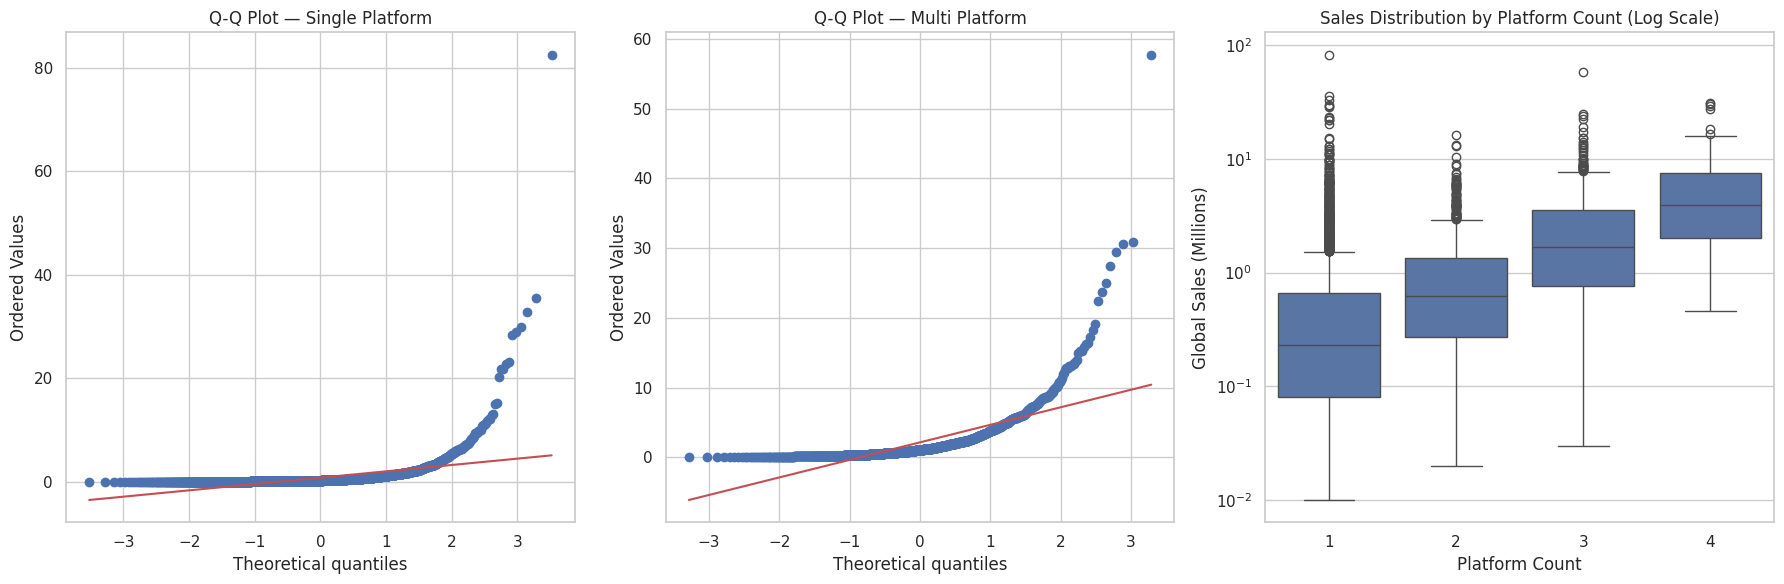

In [ ]:
# ================================
# PART 1 — LOAD & PREPROCESS
# ================================
filename = "game_centric_sales.csv"

try:
    df = pd.read_csv(filename)
    df.columns = df.columns.str.strip()
    print(f"Loaded '{filename}' successfully.")
except FileNotFoundError:
    print(f"File '{filename}' not found.")
    raise

# Detect raw vs aggregated
if "Platform" in df.columns:
    print("[Status] Raw dataset detected → Running aggregation...")

    aggregation_rules = {
        'Global_Sales': 'sum',
        'NA_Sales': 'sum',
        'EU_Sales': 'sum',
        'JP_Sales': 'sum',
        'Other_Sales': 'sum',
        'Critic_Count': 'max',
        'User_Count': 'max',
        'Year_of_Release': 'min',
        'Genre': 'first',
        'Publisher': 'first',
        'Rating': 'first',
        'Critic_Score': 'mean',
        'User_Score': 'mean',
        'Platform': 'nunique'
    }

    df = df.groupby("Name").agg(aggregation_rules).reset_index()
    df.rename(columns={'Platform': 'Platform_Count'}, inplace=True)
    df = df.sort_values(by='Global_Sales', ascending=False)

    print("[Status] Aggregation complete.")

elif "Platform_Count" in df.columns:
    print("[Status] Aggregated dataset detected → Skipping aggregation.")
else:
    raise ValueError("Error: dataset missing Platform/Platform_Count")


# ================================
# PART 2 — STATISTICAL INFERENCE
# ================================

single_platform = df[df["Platform_Count"] == 1]["Global_Sales"]
multi_platform  = df[df["Platform_Count"] > 1]["Global_Sales"]

print(f"\nSample sizes → Single: {len(single_platform)} | Multi: {len(multi_platform)}")

# A. Normality (Shapiro)
print("\n--- A. Normality (Shapiro-Wilk) ---")
stat_s, p_s = stats.shapiro(single_platform)
stat_m, p_m = stats.shapiro(multi_platform)

print(f"Single: W={stat_s:.4f}, p={p_s:.4e}")
print(f"Multi:  W={stat_m:.4f}, p={p_m:.4e}")

if p_s < 0.05 or p_m < 0.05:
    test_type = "non-parametric"
    print("→ Distribution NOT normal → Using Mann-Whitney U.")
else:
    test_type = "parametric"
    print("→ Normal distribution → Using T-test.")

# B. Homogeneity of Variance
print("\n--- B. Levene's Test ---")
stat_l, p_l = stats.levene(single_platform, multi_platform)
print(f"Levene: Stat={stat_l:.4f}, p={p_l:.4e}")

# C. Hypothesis Test
print("\n--- C. Hypothesis Test ---")
if test_type == "non-parametric":
    stat_test, p_test = stats.mannwhitneyu(
        single_platform, multi_platform, alternative='less'
    )
    test_name = "Mann-Whitney U"
else:
    stat_test, p_test = stats.ttest_ind(
        single_platform, multi_platform, alternative='less'
    )
    test_name = "T-test"

print(f"Test Used: {test_name}")
print(f"Statistic: {stat_test}")
print(f"P-Value: {p_test:.4e}")

if p_test < 0.05:
    print("Conclusion: Multi-platform games have SIGNIFICANTLY higher sales.")
else:
    print("Conclusion: No significant difference found.")


# ================================
# PART 3 — VISUALIZATION
# ================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Q-Q plot (Single)
stats.probplot(single_platform, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot — Single Platform")

# Q-Q plot (Multi)
stats.probplot(multi_platform, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot — Multi Platform")

# Boxplot
sns.boxplot(x="Platform_Count", y="Global_Sales", data=df, ax=axes[2])
axes[2].set_yscale("log")
axes[2].set_title("Sales Distribution by Platform Count (Log Scale)")
axes[2].set_xlabel("Platform Count")
axes[2].set_ylabel("Global Sales (Millions)")

plt.tight_layout()
plt.show()

### 2. Does genre affect global sales?

### ANOVA to compare genre means<br>
Null Hypothesis: All genres have the same mean global sales.<br>
Alternative Hypothesis: At least one genre has a different mean global sales.

$$
H_0: \mu_{\text{Sports}} = \mu_{\text{Platform}} = \mu_{\text{Racing}} = \mu_{\text{Role-Playing}} = \mu_{\text{Puzzle}} = \mu_{\text{Misc}} = \mu_{\text{Shooter}} = \mu_{\text{Simulation}} = \mu_{\text{Action}} = \mu_{\text{Fighting}} = \mu_{\text{Adventure}} = \mu_{\text{Strategy}}
$$

$$
H_1: \text{At least one } \mu_{\text{genre}} \text{ is different}
$$

Included genres for ANOVA (>=2 samples): ['Sports', 'Action', 'Racing', 'Shooter', 'Platform', 'Misc', 'Role-Playing', 'Puzzle', 'Simulation', 'Fighting', 'Adventure', 'Strategy']

--- ANOVA RESULTS (Genre vs Global Sales) ---
F-statistic: 8.702175181553244
p-value: 1.8757452711867125e-15
Conclusion: REJECT H0 → At least one genre has significantly different sales.


/tmp/ipython-input-3689799302.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


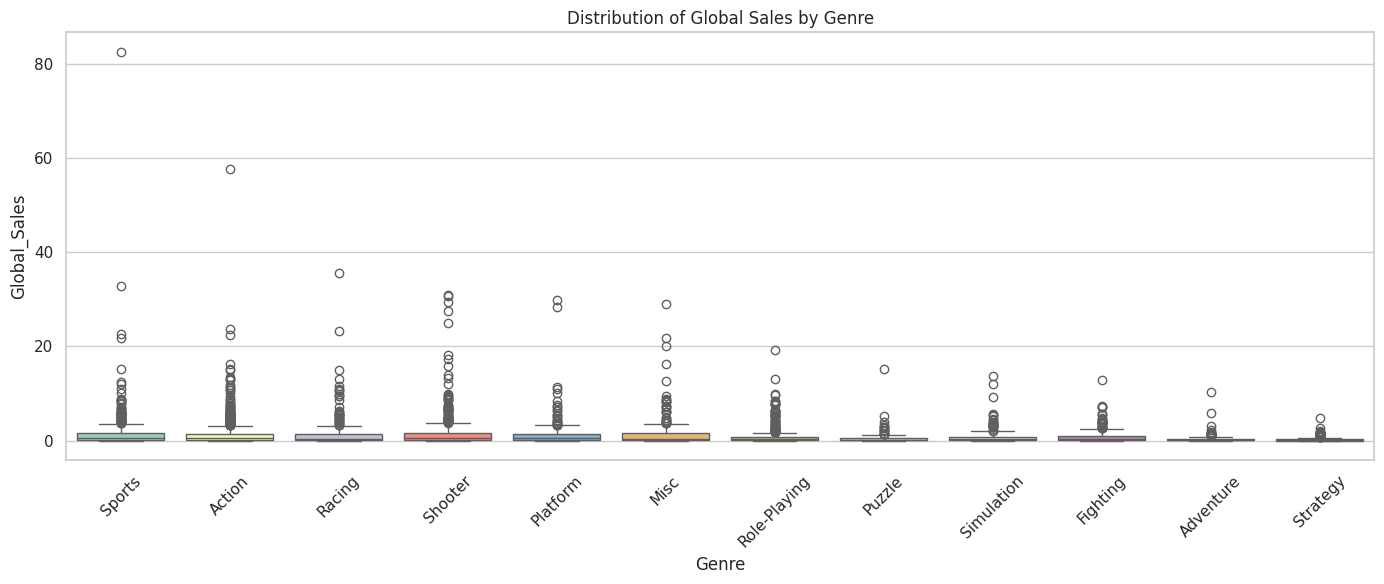

/tmp/ipython-input-3689799302.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


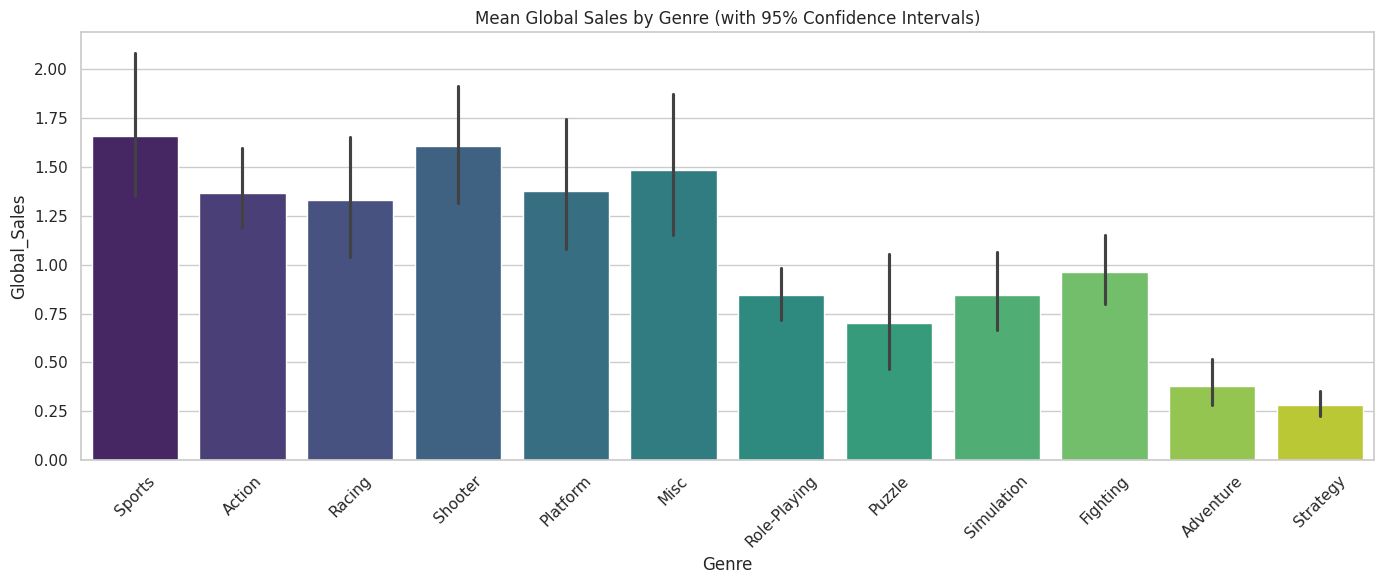

In [ ]:
# ================================
# PART 1 — ANOVA: Sales Differences by Genre
# ================================

genres = df['Genre'].unique()

# Collect sales per genre (only genres with ≥2 samples to avoid ANOVA errors)
sales_by_genre = [df[df["Genre"] == g]["Global_Sales"]
                  for g in genres
                  if len(df[df["Genre"] == g]["Global_Sales"]) >= 2]

valid_genres = [g for g in genres if len(df[df["Genre"] == g]) >= 2]

print(f"Included genres for ANOVA (>=2 samples): {valid_genres}")

# Run one-way ANOVA
f_stat, p_value = f_oneway(*sales_by_genre)

print("\n--- ANOVA RESULTS (Genre vs Global Sales) ---")
print("F-statistic:", f_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("Conclusion: REJECT H0 → At least one genre has significantly different sales.")
else:
    print("Conclusion: FAIL to reject H0 → No significant difference among genres.")


# ================================
# PART 2 — VISUALIZATION
# ================================
sns.set(style="whitegrid")


# --- 1. Boxplot (Distribution Comparison) ---
plt.figure(figsize=(14, 6))
sns.boxplot(
    x='Genre',
    y='Global_Sales',
    data=df,
    palette="Set3"
)
plt.title('Distribution of Global Sales by Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- 2. Bar Plot with Confidence Intervals (Mean Comparison) ---
plt.figure(figsize=(14, 6))
sns.barplot(
    x='Genre',
    y='Global_Sales',
    data=df,
    errorbar=('ci', 95),  # draws 95% CI
    palette="viridis"
)
plt.title('Mean Global Sales by Genre (with 95% Confidence Intervals)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Platform, Shooter, and Racing games have significantly higher average sales compared to Adventure and Strategy.

The high means in Sports, Action, and Shooter are largely driven by massive outliers (the dots way above the whiskers). These are "blockbuster" hits

We can reject null hypothesis and say that there is at least one game genre that has a different global sales mean due to the very low p value.
The F statistic is also high which means that there exists a significant amount of variation between the genres.

We can support this conclusion with the previous ERD question, the average global sales per genre,
in which we see shooters, platformers, and racing games to be the top genres,
indicating that these genres may perform better in global sales compared to the other less popular genres.

### 3. Critic and User Scores
Do higher critic or user scores affect global sales?

### For High and Low Critic Score
Null Hypothesis: There is no significant difference between the mean global sales of high and low critic scored games.<br>
Alternative Hypothesis: There is a significant difference between the mean global sales of high and low critic scored games.

$$
H_0: \mu_{\text{high}} = \mu_{\text{low}}
$$

$$
H_1: \mu_{\text{high}} \neq \mu_{\text{low}}
$$



t-statistic: 17.198830094869194
p-value (two-tailed): 2.7151772034811687e-64


/tmp/ipython-input-744686111.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


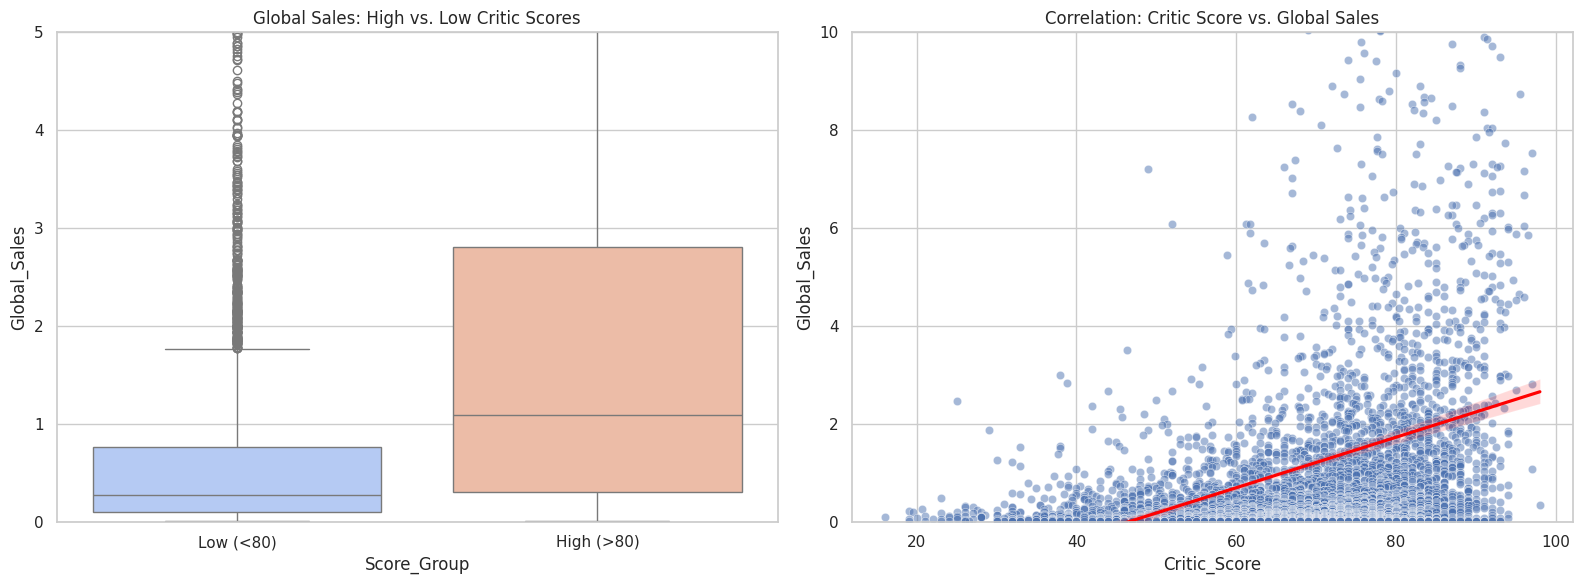

In [ ]:
# Remove duplicate games (assuming same game on different platforms = same title)
df_unique = df.drop_duplicates(subset=['Name'])

# Split groups for T-test
high_score = df_unique[df_unique['Critic_Score'] >= 80]['Global_Sales']
low_score  = df_unique[df_unique['Critic_Score'] < 80]['Global_Sales']

# Run T-test
t_stat, p_value = ttest_ind(high_score, low_score, equal_var=True, nan_policy='omit')

print("t-statistic:", t_stat)
print("p-value (two-tailed):", p_value)

# Create grouping column
df_unique['Score_Group'] = df_unique['Critic_Score'].apply(
    lambda x: 'High (>80)' if x >= 80 else 'Low (<80)'
)

# Combined plots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Boxplot ---
sns.boxplot(
    x='Score_Group',
    y='Global_Sales',
    data=df_unique,
    palette='coolwarm',
    ax=ax[0]
)
ax[0].set_title('Global Sales: High vs. Low Critic Scores')
ax[0].set_ylim(0, 5)

# --- Plot 2: Scatter w/ regression ---
sns.scatterplot(
    x='Critic_Score',
    y='Global_Sales',
    data=df_unique,
    alpha=0.5,
    ax=ax[1]
)
sns.regplot(
    x='Critic_Score',
    y='Global_Sales',
    data=df_unique,
    scatter=False,
    color='red',
    ax=ax[1]
)
ax[1].set_title('Correlation: Critic Score vs. Global Sales')
ax[1].set_ylim(0, 10)

plt.tight_layout()
plt.show()


Though it may be a driver but not always, having higher critic scores equate to increased sales in games.

### For High and Low User Score
Null Hypothesis: There is no significant difference between the mean global sales of high and low user scored games.<br>
Alternative Hypothesis: There is a significant difference between the mean global sales of high and low user scored games.

$$
H_0: \mu_{\text{high}} = \mu_{\text{low}}
$$

$$
H_1: \mu_{\text{high}} \neq \mu_{\text{low}}
$$

T-statistic: 3.6350471875543438
P-value: 0.00028184044421375416


/tmp/ipython-input-478119069.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='User_Score_Group', y='Global_Sales', data=df_clean, palette='coolwarm', ax=ax[0])


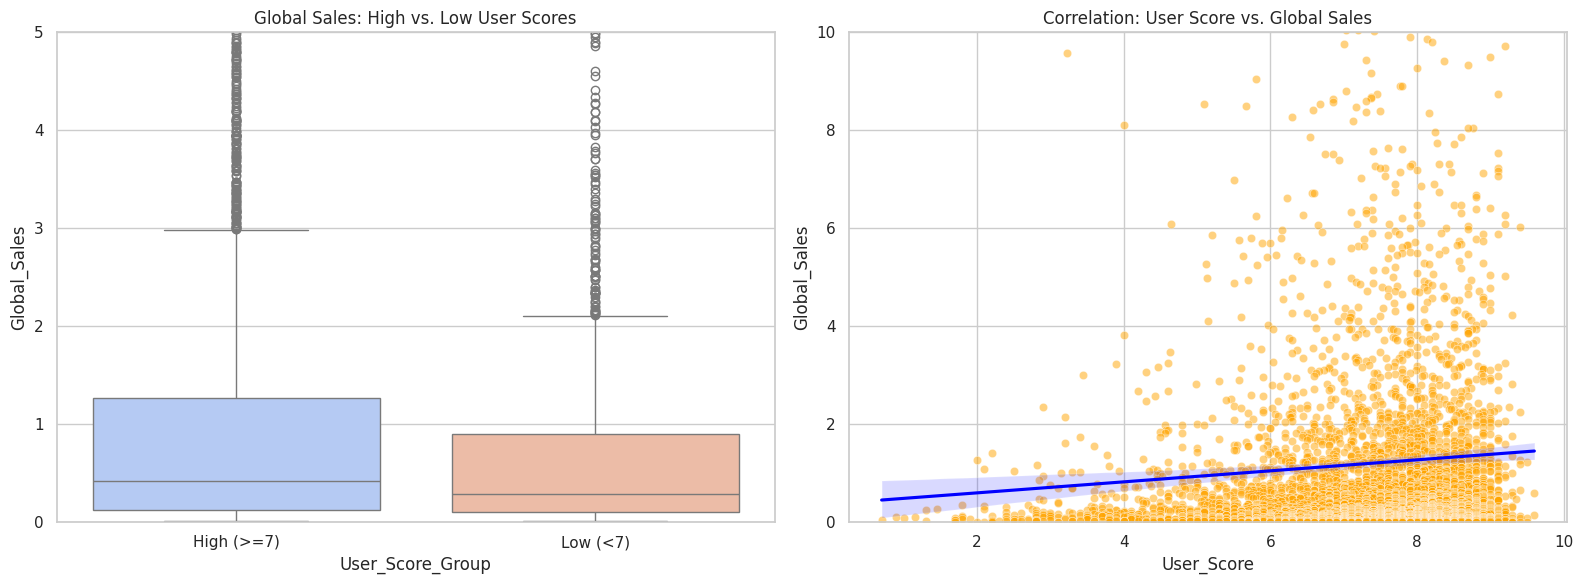

In [ ]:
df_clean = df.drop_duplicates(subset=['Name']).copy()

# Critical Step: 'User_Score' often contains 'tbd' or strings.
# We coerce errors to NaN, then drop them.
df_clean['User_Score'] = pd.to_numeric(df_clean['User_Score'], errors='coerce')
df_clean = df_clean.dropna(subset=['User_Score'])

# 2. DEFINE GROUPS (Using your logic)
high_user = df_clean[df_clean['User_Score'] >= 7]['Global_Sales']
low_user = df_clean[df_clean['User_Score'] < 7]['Global_Sales']

# 3. STATISTICAL TEST
# equal_var=False is safer (Welch's t-test) as variances likely differ between groups
t_stat, p_value = stats.ttest_ind(high_user, low_user, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# 4. VISUALIZATION
# Create a helper column for the plot
df_clean['User_Score_Group'] = df_clean['User_Score'].apply(lambda x: 'High (>=7)' if x >= 7 else 'Low (<7)')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Box Plot: Shows the spread and outliers
sns.boxplot(x='User_Score_Group', y='Global_Sales', data=df_clean, palette='coolwarm', ax=ax[0])
ax[0].set_title('Global Sales: High vs. Low User Scores')
ax[0].set_ylim(0, 5) # Zoom in to ignore extreme outliers for clarity

# Scatter Plot: Shows the correlation (or lack thereof)
sns.scatterplot(x='User_Score', y='Global_Sales', data=df_clean, alpha=0.5, ax=ax[1], color='orange')
# Add a trend line
sns.regplot(x='User_Score', y='Global_Sales', data=df_clean, scatter=False, color='blue', ax=ax[1])
ax[1].set_title('Correlation: User Score vs. Global Sales')
ax[1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

Critic Scores: Gatekeepers of quality. If Critics hate it, it usually flops. If they love it, it has a high chance of selling well.

User Scores: A measure of sentiment, not sales. High sales often generate "haters," driving user scores down.

In [ ]:
df.to_csv("Video_Game_Sales_Current.csv", index=False)